In [146]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import re
import nltk
stemmer = nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline
data = pd.read_csv("twitter.csv")
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [147]:
data["labels"] = data["class"]
data.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,labels
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [148]:
data = data[["tweet", "labels"]]
data.head()

,tweet,labels
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [149]:
# nltk.download('stopwords')
stopword=set(stopwords.words('english'))

def clean(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text
data["tweet"] = data["tweet"].apply(clean)
data.head()

,tweet,labels
0,rt mayasolov woman shouldnt complain clean ho...,2
1,rt boy dat coldtyga dwn bad cuffin dat hoe ...,1
2,rt urkindofbrand dawg rt ever fuck bitch sta...,1
3,rt cganderson vivabas look like tranni,1
4,rt shenikarobert shit hear might true might f...,1


In [150]:
x = np.array(data["tweet"])
y = torch.tensor(data.labels)
y = F.one_hot(y,num_classes=3).float()

tv = TfidfVectorizer()
X = tv.fit_transform(x) # Fit the Data
X = torch.tensor(X.toarray())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [151]:
y_train.shape

torch.Size([16604, 3])

In [152]:
n_inp = X_train.shape
sz=n_inp[1]
sz

25693

In [153]:
class Linear:
    def __init__(self,n_in,n_out):
        self.weight=torch.randn((n_in,n_out),generator=g)*(5 / (3*(n_in)**0.5))
        self.bias  =torch.zeros(n_out)
    def __call__(self,x):
        self.out = x @ self.weight
        self.out+=self.bias
        return self.out
    def params(self):
        return [self.weight]+[self.bias]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def params(self):
        return []


In [154]:
hidd=100
n_out=3
g = torch.Generator().manual_seed(252718)

layers=[
    Linear(sz,hidd),Tanh(),
    Linear(hidd,3)
]
parameters = [p for layer in layers for p in layer.params()]
for p in parameters:
    p.requires_grad=True

In [155]:
epochs=5000
batch_size=30
lossi=[]

for i in range(epochs):
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
    Xb, Yb = X_train[ix], y_train[ix]
    
    x=Xb.float()
    for layer in layers:
        x=layer(x)
    loss=F.cross_entropy(x,Yb.float())
    
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad=None
    loss.backward()
    
    lr = 0.05 #if i < 1500 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 100 == 0: # print every once in a while
        print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
    lossi.append(loss.item())

      0/   5000: 1.0933
    100/   5000: 0.6778
    200/   5000: 0.7156
    300/   5000: 0.6601
    400/   5000: 0.6460
    500/   5000: 0.7233
    600/   5000: 0.6852
    700/   5000: 0.5427
    800/   5000: 0.5694
    900/   5000: 0.5882
   1000/   5000: 0.6667
   1100/   5000: 0.6814
   1200/   5000: 0.4846
   1300/   5000: 0.4756
   1400/   5000: 0.4698
   1500/   5000: 0.7084
   1600/   5000: 0.4090
   1700/   5000: 0.6546
   1800/   5000: 0.3024
   1900/   5000: 0.3953
   2000/   5000: 0.2313
   2100/   5000: 0.3263
   2200/   5000: 0.2027
   2300/   5000: 0.3165
   2400/   5000: 0.6676
   2500/   5000: 0.5587
   2600/   5000: 0.3123
   2700/   5000: 0.4171
   2800/   5000: 0.4443
   2900/   5000: 0.4481
   3000/   5000: 0.2592
   3100/   5000: 0.3615
   3200/   5000: 0.3621
   3300/   5000: 0.3032
   3400/   5000: 0.3482
   3500/   5000: 0.4671
   3600/   5000: 0.4274
   3700/   5000: 0.3284
   3800/   5000: 0.3528
   3900/   5000: 0.2741
   4000/   5000: 0.2165
   4100/   5000:

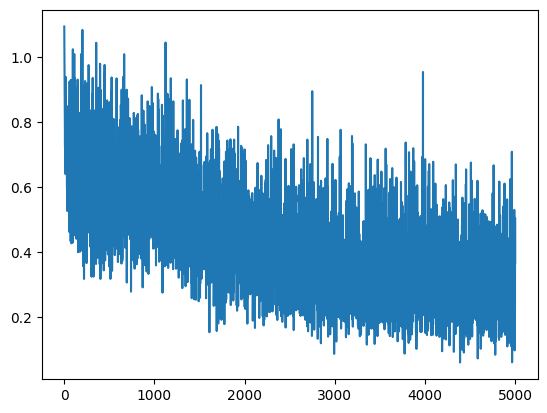

In [156]:
plt.plot(lossi)

In [158]:
def accuracy(X,y):
    x=X.float()
    for layer in layers:
        x=layer(x)
    count=0
    for i in range(len(x)):
        if y[i][torch.argmax(x[i]).item()].item()==1:
            count+=1
    return 100*(count/int(y.shape[0]))

In [159]:
accuracy(X_test,y_test)# accuracy on testing data

88.89839833720504